In [55]:
%matplotlib inline
from imports import *
import effect_size
from tqdm.notebook import tqdm
from datetime import datetime

# Load data

In [56]:
commits = pd.read_csv('../data/commits.csv')
files = pd.read_csv('../data/touched_files.csv')
lines = pd.read_csv('../data/touched_lines.csv')
commits['date'] = commits['date'].apply(datetime.fromtimestamp)

for x in [commits, files, lines]:
    x['v1'] = x['v1..v2'].apply(lambda d: d.split('..')[0].replace('v',''))
    x['v2'] = x['v1..v2'].apply(lambda d: d.split('..')[1].replace('v',''))
    x.drop('v1..v2', axis=1, inplace=True)
    x.fillna('undefined',inplace=True)
    x['repo'] = x['owner']+'/'+x['repo']

In [57]:
commits.repo.unique().size

11185

In [58]:
commits.sample()

,id,role,owner,repo,commit,author,email,date,v1,v2
1342377,5671,nodejs,HanXHX,HanXHX/ansible-nodejs,bdb300401559006ee275b3b6721e74973af07750,Emilien Mantel,emilien.mantel@gmail.com,2017-01-03 17:45:01,4b825dc642cb6eb9a060e54bf8d69288fbee4904,1.2.0


In [59]:
print(commits.id.unique().size, lines.id.unique().size, files.id.unique().size)

11309 11309 11309


In [60]:
len(commits[['repo']].drop_duplicates())

11185

# Remove repos that refer to multiples projects

In [61]:
df_tmp = (commits[['id','role','repo']].drop_duplicates().groupby('repo').count()[['role']].reset_index())
df_tmp = df_tmp.query('role >1')

commits = commits[~commits.repo.isin(df_tmp.repo)]
lines = lines[~lines.repo.isin(df_tmp.repo)]
files = files[~files.repo.isin(df_tmp.repo)]

releases = (commits[['id','v1','v2','date']]
            .sort_values('date')
            .groupby(['id','v1','v2'])
            .first()
            .reset_index()
           )

In [62]:
releases.sample()

,id,v1,v2,date
30319,17382,1.5.0,1.5.1,2015-06-02 15:29:58


In [63]:
print(releases.id.unique().size, commits.id.unique().size, lines.id.unique().size, files.id.unique().size)

11178 11178 11178 11178


In [64]:
len(commits[['repo']].drop_duplicates())

11178

# RQ0: SEMVER syntaxe compliance

In [65]:
RE_SEMVER = r'^(?:v|V)?(?P<v_major>\d+)\.(?P<v_minor>\d+)\.(?P<v_patch>\d+)(?P<v_misc>.*)$'
def comply_semver(series_of_releases):
    extracted = series_of_releases.str.extract(RE_SEMVER, expand=True)
    return (
        extracted
        [['v_major', 'v_minor', 'v_patch']]
        .astype('str')
        .assign(Semver=lambda d: d['v_major'] + '.' + d['v_minor'] + '.' + d['v_patch'])
        ['Semver']
    )

In [67]:
for x in [releases, commits, files, lines]:
    x['fromm'] = comply_semver(x['v1'])
    x['tot'] = comply_semver(x['v2'])

In [68]:
def type_release(v0,v1,v2):
    if v0 == "4b825dc642cb6eb9a060e54bf8d69288fbee4904":
        return 'initial'
    v1=v1.split('.')
    v2=v2.split('.')
    
    if v1[-1] == 'nan' or v2[-1] == "nan":
        return 'notSemver'
    if v1[0]!=v2[0]:
        return 'major'
    if v1[1]!=v2[1]:
        return 'minor'
    if v1[2]!=v2[2]:
        return 'patch'
    return 'pre'

for x in [ releases, commits, files, lines]:
    x['release'] = x.apply(lambda d: type_release(d['v1'], d['fromm'], d['tot']), axis=1)

In [69]:
# Don't remove duplicates
releases.groupby('release').count()

,id,v1,v2,date,fromm,tot
release,,,,,,
initial,11178,11178,11178,11178,11178,11178
major,3254,3254,3254,3254,3254,3254
minor,15280,15280,15280,15280,15280,15280
notSemver,5545,5545,5545,5545,5545,5545
patch,48267,48267,48267,48267,48267,48267
pre,559,559,559,559,559,559


In [71]:
len(releases.query('tot != "nan.nan.nan"'))*100/len(releases), len(releases.query('tot != "nan.nan.nan"'))

(92.33733334919069, 77640)

In [72]:
releases.query('tot == "nan.nan.nan"').id.unique().size

2008

In [73]:
# Number of projects that only have not complying version numbers.
mask = releases.query('tot != "nan.nan.nan"').id.isin(releases.query('tot == "nan.nan.nan"').id)
releases.query('tot == "nan.nan.nan"').id.unique().size - releases.query('tot != "nan.nan.nan"')[mask].id.unique().size

1128

In [74]:
len(releases), releases.id.unique().size

(84083, 11178)

In [75]:
mask = releases.v2.str.contains('-')
releases[mask].query('tot != "nan.nan.nan"').id.unique().size, len(releases[mask].query('tot != "nan.nan.nan"'))

(237, 701)

In [76]:
len(releases.query('release == "pre"')), len(releases[mask].query('tot != "nan.nan.nan"'))*100.0/len(releases)

(559, 0.8337000344897304)

In [77]:
releases.query('release == "pre"').id.unique().size

213

In [78]:
commits = commits.query('release != "notSemver" and release != "pre"')
lines = lines.query('release != "notSemver" and release != "pre"')
files = files.query('release != "notSemver" and release != "pre"')
releases = releases.query('release != "notSemver" and release != "pre"')

In [ ]:
releases.fromm = releases.fromm.replace({'nan.nan.nan':'first commit'})
lines.fromm = lines.fromm.replace({'nan.nan.nan':'first commit'})
commits.fromm = commits.fromm.replace({'nan.nan.nan':'first commit'})
files.fromm = files.fromm.replace({'nan.nan.nan':'first commit'})

In [80]:
print(len(releases),len(commits), len(lines), len(files))

77979 495841 79015 642298


In [82]:
print(releases.id.unique().size,commits.id.unique().size, lines.id.unique().size, files.id.unique().size)

11178 11178 11178 11177


([<matplotlib.axis.YTick at 0x7fe19eb0a630>,
 <a list of 7 Text yticklabel objects>)

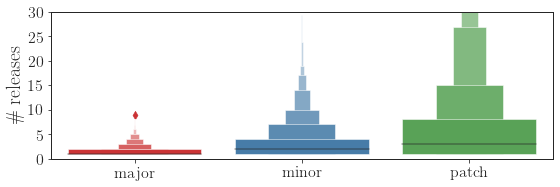

In [84]:
# Number of releases per project
df_tmp = (releases
          .groupby(['id','release'])
          .count()[['fromm']]
          .reset_index()
          .query('release != "initial"')
         )
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True)
fig.set_size_inches(9,2.7)
ax = sns.boxenplot(x="release", 
                 y="fromm",
                 data=df_tmp, 
                 order = ['major','minor','patch'],
                 palette='Set1',
                 linewidth=1,
                  )
ax.set(
    xlabel='',
    ylabel='\# releases',
    ylim=(0,30)
)
plt.yticks(pd.np.arange(0, 31, 5)) 

In [85]:
for r in ['major','minor','patch']:
    print(r, df_tmp.query('release =="{}"'.format(r))['fromm'].median())

major 1.0
minor 2.0
patch 3.0


In [86]:
for r1 in ['major','minor','patch']:
    for r2 in ['major','minor','patch']:
        if r1<=r2:
            continue
        print((r1,r2),scipy.stats.mannwhitneyu(df_tmp.query('release =="{}"'.format(r1))['fromm'],
                                       df_tmp.query('release =="{}"'.format(r2))['fromm']))
        print(effect_size.cliffsDelta(df_tmp.query('release =="{}"'.format(r1))['fromm'],
                                       df_tmp.query('release =="{}"'.format(r2))['fromm']))

('minor', 'major') MannwhitneyuResult(statistic=2935090.5, pvalue=4.983597788659872e-150)
d=0.37240372119975174
True
('patch', 'major') MannwhitneyuResult(statistic=3111702.0, pvalue=0.0)
d=0.5574030784198403
True
('patch', 'minor') MannwhitneyuResult(statistic=11120620.5, pvalue=5.773244465185155e-96)
d=0.22916036610898746
True


In [87]:
releases['month'] = releases['date'].apply(lambda d: str(d).split('-')[0]+'-'+str(d).split('-')[1])
releases['year'] = releases['date'].apply(lambda d: str(d).split('-')[0])

tmp_releases = (releases
               .groupby(['id','release','year'])
               .count()[['fromm']]
               .reset_index()
               .query('release != "initial"'))

([<matplotlib.axis.YTick at 0x7fe1b9c49cf8>,
 <a list of 5 Text yticklabel objects>)

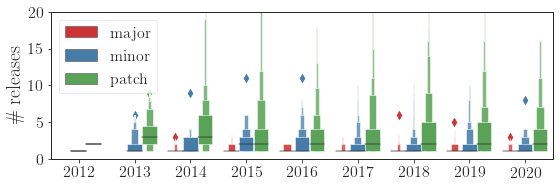

In [88]:
# Number of releases per project
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True)
fig.set_size_inches(9,2.7)
ax = sns.boxenplot(x="year", 
                 y="fromm",
                 hue = 'release',
                 data=tmp_releases, 
                 hue_order = ['major','minor','patch'],
                 palette='Set1',
                 linewidth=1,
                  )
ax.set(
    xlabel='',
    ylabel='\# releases',
    ylim=(0,20)
)
ax.legend(loc='upper left')
plt.yticks(pd.np.arange(0, 21, 5)) 

# RQ1: How often do Ansible roles release new versions?

([<matplotlib.axis.YTick at 0x7fe17010a630>,
 <a list of 5 Text yticklabel objects>)

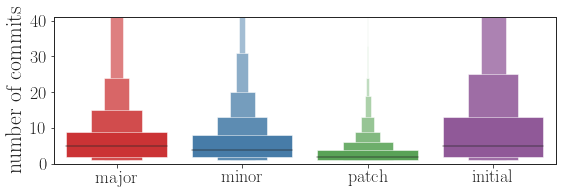

In [115]:
# Number of commits between two successive releases
df_tmp = (commits[['repo','v1','v2','release','commit']]
          .drop_duplicates()
          .groupby(['repo','release','v1','v2'])
          .count()[['commit']]
          .reset_index()
         )

fig, axes = plt.subplots(1, 1, sharex=True, sharey=True)
fig.set_size_inches(9,2.7)
ax = sns.boxenplot(x="release", 
                 y="commit",
                 data=df_tmp, 
                 order = ['major','minor','patch','initial'],
                 palette='Set1',
                 linewidth=1,
                  )
ax.set(
    xlabel='',
    ylabel='number of commits',
    ylim=(0,41)
)
plt.yticks(pd.np.arange(0, 41, 10)) 

In [116]:
for r in ['major','minor','patch','initial']:
    print(r, 'mean', df_tmp.query('release =="{}"'.format(r))['commit'].mean())
    print(r, 'median', df_tmp.query('release =="{}"'.format(r))['commit'].median())

major mean 9.96742470805163
major median 5.0
minor mean 8.331806282722512
minor median 4.0
patch mean 3.5373236372676984
patch median 2.0
initial mean 14.793433530148507
initial median 5.0


In [ ]:
releases_commits = releases[['id','v1','v2','date','release']]
releases_commits['previous'] = releases_commits.sort_values(['id','date']).groupby('id').release.shift(1)

In [92]:
print(releases.id.unique().size,commits.id.unique().size, lines.id.unique().size, files.id.unique().size)

11178 11178 11178 11177


### Let's prepare releases dataframe: it will contain the type of the previous release

In [ ]:
releases_commits = releases[['id','v1','v2','date','release']]

releases_commits['previous'] = releases_commits.sort_values(['id','date']).groupby('id').release.shift(1)

releases_commits.fillna('void', inplace=True)
releases_commits.drop(['release','date'], axis=1, inplace=True)

commits = (commits
           .merge(releases_commits,
                  on = ['id','v1','v2']
                 )
          )

lines = (lines
           .merge(releases_commits,
                  on = ['id','v1','v2']
                 )
          )

files = (files
           .merge(releases_commits,
                  on = ['id','v1','v2']
                 )
          )
print(releases.id.unique().size,commits.id.unique().size, lines.id.unique().size, files.id.unique().size)

#### Since we found that there are more patch and minor releases than major releases. We will for sure find that it takes more commits to create a major release from an other (not successive) major release.

#### For this reason, we only need to analyze the successive releases

([<matplotlib.axis.YTick at 0x7fe1664e8470>,
 <a list of 7 Text yticklabel objects>)

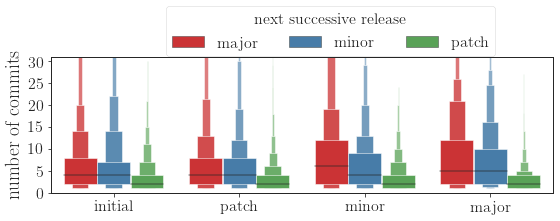

In [94]:
# Number of commits between two successive releases
df_tmp = (commits[['repo','v1','v2','release','commit','previous']]
          .drop_duplicates()
          .groupby(['repo','release','previous','v1','v2'])
          .count()[['commit']]
          .reset_index()
         )
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True)
fig.set_size_inches(9,2.5)
ax = sns.boxenplot(x="previous", 
                 y="commit",
                 hue='release',
                 order = ['initial','patch','minor','major'],
                 hue_order = ['major','minor','patch'],
                 data=df_tmp, 
                 palette='Set1',
                 linewidth=1,
                  )
ax.set(
    xlabel='',
    ylabel='number of commits',
    ylim=(0,31)
)
ax.legend( title ='next successive release', ncol=4, bbox_to_anchor= (0.9, 1.43))
plt.yticks(pd.np.arange(0, 31, 5)) 

In [95]:
lines ['changes'] = lines['deletions'] + lines['insertions']

([<matplotlib.axis.YTick at 0x7fe17cf16a20>,
 <a list of 8 Text yticklabel objects>)

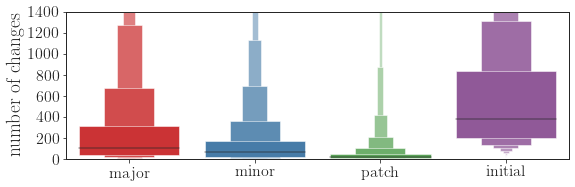

In [96]:
# Number of commits between two successive releases
# You can try with ['insertions','deletions','changes']

fig, axes = plt.subplots(1, 1, sharex=True, sharey=True)
fig.set_size_inches(9,2.7)
ax = sns.boxenplot(x="release", 
                 y="changes",
                 data=lines, 
                 order = ['major','minor','patch','initial'],
                 palette='Set1',
                 linewidth=1,
                 #showfliers= False
                  )
ax.set(
    xlabel='',
    ylabel='number of changes',
    ylim=(0,1401)
)
plt.yticks(pd.np.arange(0, 1401, 200)) 

In [119]:
for r in ['major','minor','patch','initial']:
    print(r, 'mean', lines.query('release =="{}"'.format(r))['deletions'].mean())
    print(r, 'median', lines.query('release =="{}"'.format(r))['deletions'].median())

major mean 170.46527350952672
major median 35.0
minor mean 149.32879581151832
minor median 13.0
patch mean 54.376364804110466
patch median 3.0
initial mean 0.0
initial median 0.0


([<matplotlib.axis.YTick at 0x7fe17dc959b0>,
 <a list of 5 Text yticklabel objects>)

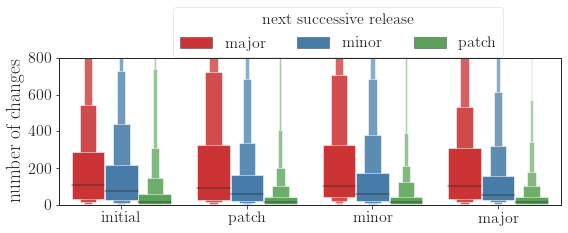

In [97]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True)
fig.set_size_inches(9,2.7)
ax = sns.boxenplot(x="previous", 
                 y='changes',
                 hue='release',
                 order = ['initial','patch','minor','major'],
                 hue_order = ['major','minor','patch'],
                 data=lines, 
                 palette='Set1',
                 linewidth=1,
                  )
ax.set(
    xlabel='',
    ylabel='number of changes',
    ylim=(0,800)
)
ax.legend( title ='next successive release', ncol=4, bbox_to_anchor= (0.9, 1.4))
plt.yticks(pd.np.arange(0, 801, 200)) 

# RQ: Continue with time


# Let's focus on changes files

In [98]:
# Let's distinguish between files and folders
files['directory'] = files.file.apply(lambda x: x.split('/')[0])
files['element'] = files.file.apply(lambda x: x.split('/')[-1])

In [99]:
# How many releases changed wich file
result_tmp = pd.DataFrame()
folders = ['tasks','defaults','meta','templates','vars']
for r in ['all','patch','minor','major','initial']:
    if r =="all":
        mask  = files.directory.isin(folders)
        tmp_files = files[['id','v1','v2','directory','release']][mask].query('release != "initial"')
        tmp_files.drop_duplicates(inplace=True)
        size = len(files
                   .query('release != "initial"')
                   [['id','v1','v2','release']]
                   .drop_duplicates())

        s = len(tmp_files
                   [['id','v1','v2','release']]
                   .drop_duplicates())
        print('proportion of {} releases analyzed {}'.format(r, s*100/size))
        tmp_files = tmp_files.groupby(['directory']).count()[['v1']].reset_index()
        tmp_files['v1'] = tmp_files['v1'].apply(lambda x: round(x*100./size,1))
        tmp_files.rename(columns={'v1':'all'}, inplace=True)
        result_tmp = tmp_files.copy()
    else:
        mask  = files.directory.isin(folders)
        tmp_files = files[['id','v1','v2','directory','release']][mask].query('release == "'+r+'"')
        tmp_files.drop_duplicates(inplace=True)
        size = len(files
                   .query('release == "'+r+'"')
                   [['id','v1','v2','release']]
                   .drop_duplicates())

        s = len(tmp_files
                   [['id','v1','v2','release']]
                   .drop_duplicates())
        print('proportion of {} releases analyzed {}'.format(r, s*100/size))
        tmp_files = tmp_files.groupby(['directory','release']).count()[['v1']].reset_index()
        
        tmp_files['v1'] = tmp_files['v1'].apply(lambda x: round(x*100./size,1))
        tmp_files = pd.pivot_table(tmp_files, values='v1', index='directory',
                        columns=['release']).reset_index()
        result_tmp = result_tmp.merge(tmp_files, on =['directory'], how='left')
result_tmp = result_tmp[['directory','patch','minor','major','all','initial']]
print(result_tmp.set_index('directory').to_latex())

proportion of all releases analyzed 82.07146182844956
proportion of patch releases analyzed 77.47311044999688
proportion of minor releases analyzed 93.51142539121325
proportion of major releases analyzed 96.35914841098426
proportion of initial releases analyzed 99.28347514554412
\begin{tabular}{lrrrrr}
\toprule
{} &  patch &  minor &  major &   all &  initial \\
directory &        &        &        &       &          \\
\midrule
defaults  &   29.0 &   56.4 &   67.9 &  37.2 &     87.6 \\
meta      &   21.8 &   35.1 &   52.7 &  26.3 &     98.4 \\
tasks     &   48.1 &   73.0 &   78.0 &  55.3 &     98.0 \\
templates &   16.1 &   32.5 &   37.5 &  20.9 &     54.3 \\
vars      &   12.5 &   24.1 &   28.1 &  16.0 &     52.8 \\
\bottomrule
\end{tabular}



In [100]:
result_tmp[['directory','initial']]

,directory,initial
0,defaults,87.6
1,meta,98.4
2,tasks,98.0
3,templates,54.3
4,vars,52.8


In [101]:
folders = ['tasks','defaults','meta','templates','vars']
mask  = files.directory.isin(folders)
tmp_files = files[['id','v1','v2','directory','release']][mask].query('release != "initial"')
tmp_files.drop_duplicates(inplace=True)
size = len(files
           .query('release != "initial"')
           [['id','v1','v2','release']]
           .drop_duplicates())

s = len(tmp_files
           [['id','v1','v2','release']]
           .drop_duplicates())
print('proportion of releases analyzed {}'.format(s*100/size))

tmp_files = tmp_files.groupby(['directory','release']).count()[['v1']].reset_index()
tmp_files['v1'] = tmp_files['v1'].apply(lambda x: round(x*100./size,1))
tmp_files = pd.pivot_table(tmp_files, values='v1', index='directory',
                    columns=['release']).reset_index()
tmp_files['total'] = (tmp_files['major']+tmp_files['minor']+tmp_files['patch'])
print(tmp_files.set_index('directory').to_latex())

proportion of releases analyzed 82.07146182844956
\begin{tabular}{lrrrr}
\toprule
release &  major &  minor &  patch &  total \\
directory &        &        &        &        \\
\midrule
defaults  &    3.3 &   12.9 &   21.0 &   37.2 \\
meta      &    2.6 &    8.0 &   15.7 &   26.3 \\
tasks     &    3.8 &   16.7 &   34.7 &   55.2 \\
templates &    1.8 &    7.5 &   11.7 &   21.0 \\
vars      &    1.4 &    5.5 &    9.1 &   16.0 \\
\bottomrule
\end{tabular}



In [102]:
# Prepare for the venn diagram 

def prepare_venn(files, r=None):
    folders = ['tasks','defaults','meta','templates','vars']
    number={}
    number['tasks']=10000
    number['defaults']=1000
    number['meta']=100
    number['templates']=10
    number['vars']=1

    mask  = files.directory.isin(folders)
    if r:
        tmp_files = files[['id','v1','v2','directory','release']][mask].query('release == "'+r+'"')
    else:
        tmp_files = files[['id','v1','v2','directory','release']][mask].query('release != "initial"')

    tmp_files['number'] = tmp_files['directory'].apply(lambda x: number[x])
    tmp_files.drop_duplicates(inplace=True)    

    tmp_files = pd.pivot_table(tmp_files, values='number', index=['id', 'v1','v2','release'],
                        columns=['directory']).reset_index().fillna(0)

    tmp_files['number'] = (tmp_files['defaults']+tmp_files['meta']+tmp_files['tasks']
                           +tmp_files['templates']+tmp_files['vars']).apply(int).apply(lambda x: str("%05d"%(x,)))

    tmp_files = tmp_files.groupby('number').count()[['release']].reset_index()

    if r:
        size = len(files
                   .query('release == "'+r+'"')
                   [['id','v1','v2','release']]
                   .drop_duplicates())
    else:
        size = len(files
                   .query('release != "initial"')
                   [['id','v1','v2','release']]
                   .drop_duplicates())
        
    tmp_files['release'] = tmp_files['release'].apply(lambda x: round(x*100./size,1))
    print('proportion of releases analyzed {}'.format(tmp_files.release.sum()))
    
    venn_results = dict(zip(tmp_files.number.tolist(), tmp_files.release.tolist()))
    return venn_results

No handles with labels found to put in legend.


proportion of releases analyzed 82.3


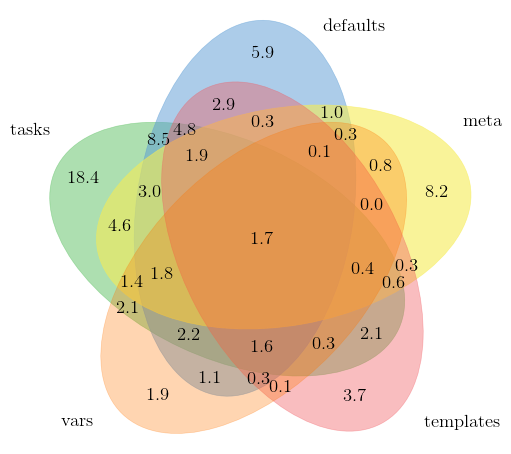

In [103]:
%matplotlib inline
#https://github.com/tctianchi/pyvenn
import ven as venn
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)

venn_results = prepare_venn(files)

fig, ax = venn.venn5(venn_results, names=folders)
ax.legend().remove()
fig.set_size_inches(6,6)

No handles with labels found to put in legend.


proportion of releases analyzed 77.6


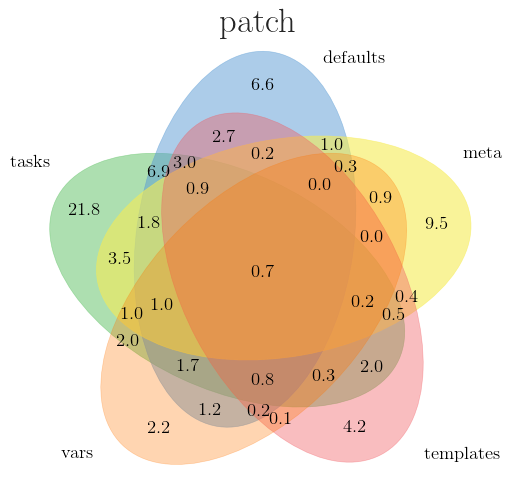

No handles with labels found to put in legend.


proportion of releases analyzed 93.59999999999998


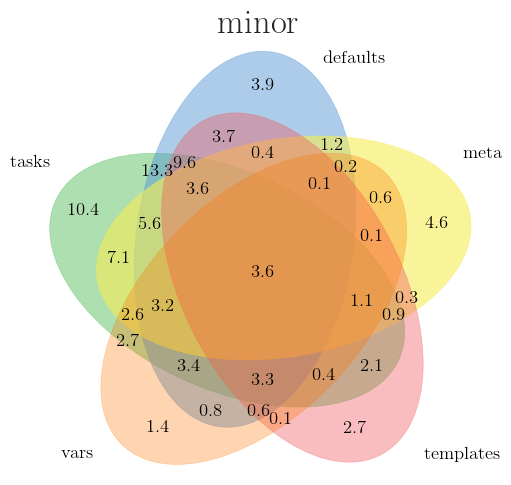

No handles with labels found to put in legend.


proportion of releases analyzed 96.4


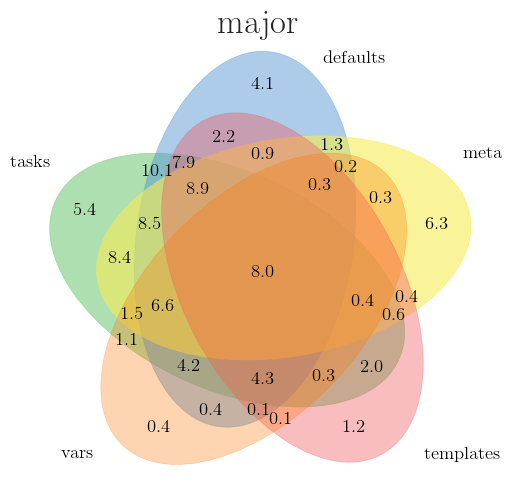

In [104]:
for index, r in enumerate(['patch','minor','major']):
    venn_results = prepare_venn(files, r)
    fig, ax = venn.venn5(venn_results, names=folders)
    ax.legend().remove()
    ax.set_title(r)
    fig.set_size_inches(6,6)
    plt.show(fig)

In [105]:
# 
df_tmp=(files
        .query('directory != element') # consider only files
        .query('release != "initial"') # Remove the first release
        [['id','v1','v2','directory','release']]
        .drop_duplicates()
        .groupby('directory')
        .count()
        .sort_values('release', ascending=False)
        [['release']]
        .reset_index()
)

size = len(files
     #.query('directory != element') # consider only files
     .query('release != "initial"') # Remove the first release
     [['id','v1','v2','release']]
     .drop_duplicates())

df_tmp['versions'] = df_tmp.release*100./size
list_files = df_tmp.head(8).directory

In [106]:
df_tmp.head(10)

,directory,release,versions
0,tasks,36790,55.256004
1,defaults,24773,37.207311
2,meta,17532,26.331836
3,templates,13940,20.936904
4,vars,10629,15.964014
5,tests,9833,14.768477
6,molecule,8139,12.224208
7,handlers,4607,6.919391
8,files,1872,2.811613
9,.github,1793,2.692960


In [107]:
len(files.query('release != "initial"')[['id','v1','v2']].drop_duplicates()), size

(66581, 66581)

(0, 100)

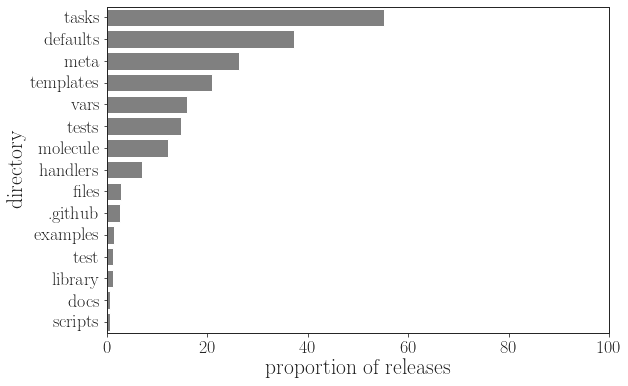

In [109]:
ax = sns.barplot(x="versions", 
                 y="directory", 
                 data=df_tmp.head(15), 
                 color='gray',
                 linewidth=1)
ax.figure.set_size_inches(9,6)
#ax.set_xlabel("")
ax.set_xlabel('proportion of releases')
ax.set_xlim(0,100)


In [332]:
df_tmp=(files
        .query('directory != element')
        .query('v1 != "4b825dc642cb6eb9a060e54bf8d69288fbee4904"')
        [['id','v1','v2','directory','release']]
 .drop_duplicates()
 .groupby(['release','directory'])
 .count()
 .sort_values('id', ascending=False)
 [['id']]
 .reset_index()
)

df_tmp =  df_tmp[df_tmp.directory.isin(list_files)]


df_tmp2=(files
        [['id','v1','v2','release']]
 .drop_duplicates()
 .groupby('release')
 .count()
 [['v1']]
 .reset_index()
)

df_tmp = (df_tmp
          .merge(df_tmp2,
                 on = ['release'])
         )
df_tmp ['versions'] = df_tmp ['id']*100./df_tmp ['v1']
df_tmp.sample()

,release,directory,id,v1,versions
18,major,meta,1707,3241,52.668929


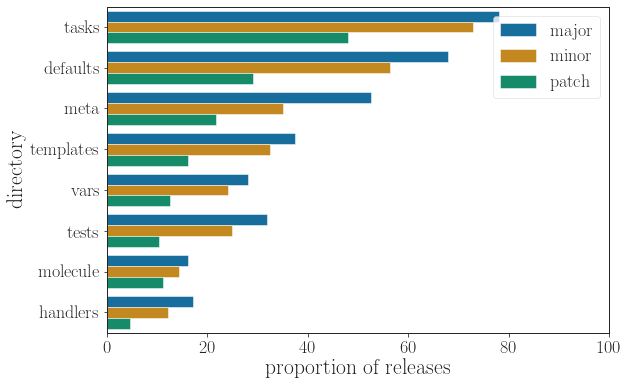

In [333]:
ax = sns.barplot(y="directory", 
                 x="versions", 
                 hue = 'release',
                 data=df_tmp, 
                 order=list_files,
                 hue_order = ['major','minor','patch'],
                 #color='blue'
                )
ax.figure.set_size_inches(9,6)
#ax.set_xlabel("")
ax.set_xlabel('proportion of releases')
ax.set_xlim(0,100)
ax.legend(loc='upper right') #handles=legend_elements, 

# Comment: Use stacked barplots

In [ ]:
df_tmp= files[files.directory.isin(list_files)]
df_tmp['changes'] = df_tmp['insertions'] + df_tmp['deletions']
df_tmp = df_tmp[['directory','release','changes','deletions','insertions']]

In [ ]:
ax = sns.boxenplot(x="changes", 
                 y="directory", 
                 hue='release',
                 order = list_files,
                 hue_order = ['major','minor','patch'],
                 data=df_tmp, 
                 linewidth=1)
ax.figure.set_size_inches(9,10)
ax.set_xlim(0,80)

(0, 40)

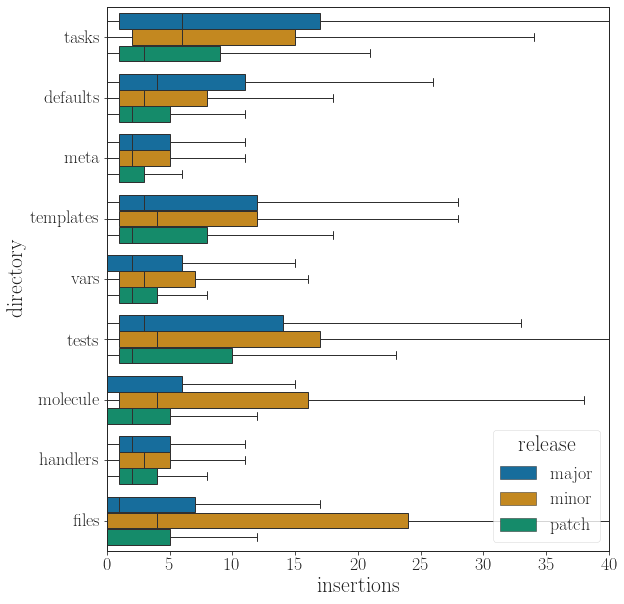

In [324]:
ax = sns.boxplot(x="insertions", 
                 y="directory", 
                 hue='release',
                 order = list_files,
                 hue_order = ['major','minor','patch'],
                 data=df_tmp, 
                 showfliers=False,
                 linewidth=1)
ax.figure.set_size_inches(9,10)
ax.set_xlim(0,40)


(0, 60)

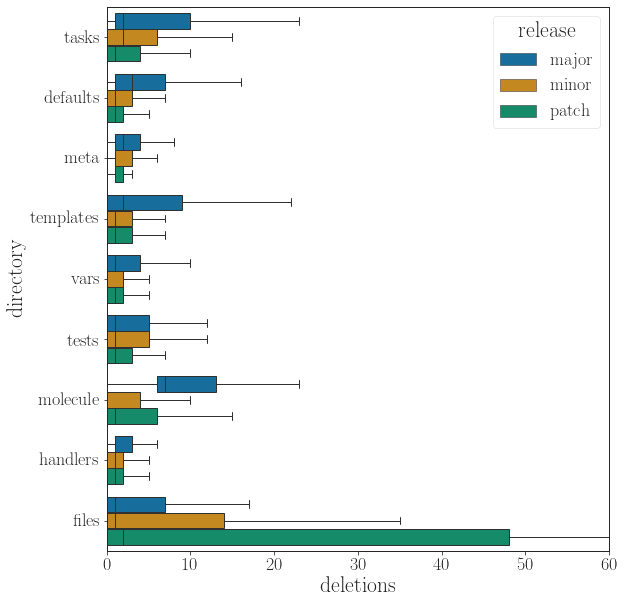

In [323]:
ax = sns.boxplot(x="deletions", 
                 y="directory", 
                 hue='release',
                 order = list_files,
                 hue_order = ['major','minor','patch'],
                 data=df_tmp, 
                 showfliers=False,
                 linewidth=1)
ax.figure.set_size_inches(9,10)
ax.set_xlim(0,60)

(0, 100)

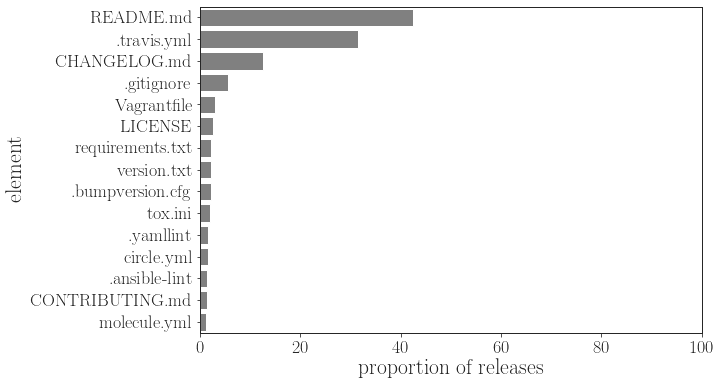

In [325]:
df_tmp=(files
        .query('directory == element')
        .query('v1 != "4b825dc642cb6eb9a060e54bf8d69288fbee4904"')
        [['id','v1','v2','element','release']]
 .drop_duplicates()
 .groupby('element')
 .count()
 .sort_values('release', ascending=False)
 [['release']]
 .reset_index()
)
df_tmp['versions'] = df_tmp.release*100./len(files[['id','v1','v2','release']].query('v1 != "4b825dc642cb6eb9a060e54bf8d69288fbee4904"').drop_duplicates())
list_elements = df_tmp.head(9).element

ax = sns.barplot(x="versions", 
                 y="element", 
                 data=df_tmp.head(15), 
                 color='gray',
                 linewidth=1)
ax.figure.set_size_inches(9,6)
ax.set_xlabel('proportion of releases')
ax.set_xlim(0,100)

(0, 100)

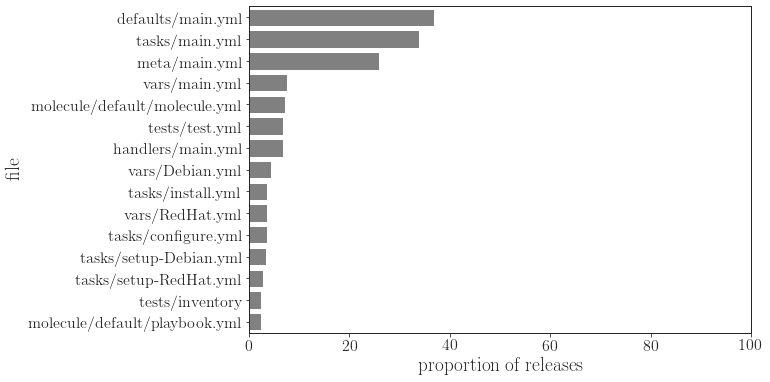

In [406]:
df_tmp=(files
        .query('directory != element')
        .query('v1 != "4b825dc642cb6eb9a060e54bf8d69288fbee4904"')
        [['repo','v1','v2','file','release']]
 .drop_duplicates()
 .groupby('file')
 .count()
 .sort_values('release', ascending=False)
 [['release']]
 .reset_index()
)
df_tmp['versions'] = df_tmp.release*100./len(files[['repo','v1','v2','release']].query('v1 != "4b825dc642cb6eb9a060e54bf8d69288fbee4904"').drop_duplicates())
list_elements = df_tmp.head(15).file

ax = sns.barplot(x="versions", 
                 y="file", 
                 data=df_tmp.head(15), 
                 color='gray',
                 linewidth=1)
ax.figure.set_size_inches(9,6)
ax.set_xlabel('proportion of releases')
ax.set_xlim(0,100)

# IGNORE THIS

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=False)
fig.set_size_inches(9,9)
for index, release in enumerate(['patch','minor','major']):
    size=[12,20,70]
    df_tmp=(tmp_commits
         .query('release=="{}"'.format(release))
         .groupby(pd.Grouper(key='year', freq='1Y'))['from']
         .describe()[['mean', '25%', '50%', '75%']] 
        )

    df_tmp['50%'].rename('median').plot(ax=axes, color=flatui[index])
    ax=df_tmp['mean'].plot(ax=axes, style=':',color=flatui[index])
    ax.fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], alpha=0.2, color=flatui[index])
    
    ax.set(
        xlabel='',
        ylabel='number of releases',
        title=release,
    )
    ax.legend(loc='upper center', prop={'size': 16}, ncol=2, ) #handles=legend_elements, 

# Let's check version 0.x.y

In [339]:
releases['zero'] = releases['v1'].apply(lambda x: x.startswith('0.'))

In [341]:
releases['date_previous'] = releases.sort_values(['id','date']).groupby('id').date.shift(1)

In [379]:
releases_zero = releases.query('release != "initial"').sort_values('date_previous').dropna()

In [380]:
releases_zero['days'] = (releases_zero['date'] - releases_zero['date_previous']).dt.days

In [373]:
mask = releases_zero.id.isin(releases_zero.query('zero == True').id)
releases_zero = releases_zero[mask]

In [378]:
releases.id.unique().size

11178

[(0, 900), Text(0, 0.5, 'days'), Text(0.5, 0, '')]

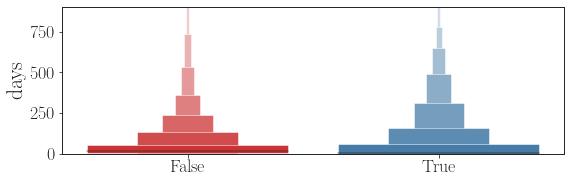

In [381]:
# Number of commits between two successive releases
# You can try with ['insertions','deletions','changes']

fig, axes = plt.subplots(1, 1, sharex=True, sharey=True)
fig.set_size_inches(9,2.7)
ax = sns.boxenplot(x="zero", 
                 y="days",
                 data=releases_zero, 
                 palette='Set1',
                 linewidth=1,
                  )
ax.set(
    xlabel='',
    ylabel='days',
    ylim=(0,900)
)

In [384]:
print('Mannwhitney U test')
scipy.stats.mannwhitneyu(releases_zero.query('zero == True').days,
                         releases_zero.query('zero == False').days)
print("Cliff's Delta")
effect_size.cliffsDelta(releases_zero.query('zero == True').days,
                         releases_zero.query('zero == False').days)

Mannwhitney U test
Cliff's Delta
d=-0.13722885305776839


False